<a href="https://colab.research.google.com/github/MauricioCastroF/NLP-desafios/blob/main/Desaf%C3%ADo_4_NLP_CastroFMauricio_TextPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicción de próxima palabra

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset de un cuento de Gabriel García Marquez

In [2]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/sample_data/gabo.txt', sep='/n', header=None)
df.head()

<ipython-input-2-0d51fe0837c7>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/sample_data/gabo.txt', sep='/n', header=None)


,0
0,Imagínese usted un pueblo muy pequeño donde ha...
1,"No sé, pero he amanecido con el presentimiento..."
2,Ellos se ríen de la madre. Dicen que esos son ...
3,Te apuesto un peso a que no la haces.
4,Todos se ríen. Él se ríe. Tira la carambola y ...


In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 39


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [4]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [5]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Imagínese usted un pueblo muy pequeño donde hay una señora vieja que tiene dos hijos, uno de 17 y una hija de 14. Está sirviéndoles el desayuno y tiene una expresión de preocupación. Los hijos le preguntan qué le pasa y ella les responde:'

In [6]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['imagínese',
 'usted',
 'un',
 'pueblo',
 'muy',
 'pequeño',
 'donde',
 'hay',
 'una',
 'señora',
 'vieja',
 'que',
 'tiene',
 'dos',
 'hijos',
 'uno',
 'de',
 '17',
 'y',
 'una',
 'hija',
 'de',
 '14',
 'está',
 'sirviéndoles',
 'el',
 'desayuno',
 'y',
 'tiene',
 'una',
 'expresión',
 'de',
 'preocupación',
 'los',
 'hijos',
 'le',
 'preguntan',
 'qué',
 'le',
 'pasa',
 'y',
 'ella',
 'les',
 'responde']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [7]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [8]:
# Demos un vistazo
sentence_tokens[:2]

[['imagínese',
  'usted',
  'un',
  'pueblo',
  'muy',
  'pequeño',
  'donde',
  'hay',
  'una',
  'señora',
  'vieja',
  'que',
  'tiene',
  'dos',
  'hijos',
  'uno',
  'de',
  '17',
  'y',
  'una',
  'hija',
  'de',
  '14',
  'está',
  'sirviéndoles',
  'el',
  'desayuno',
  'y',
  'tiene',
  'una',
  'expresión',
  'de',
  'preocupación',
  'los',
  'hijos',
  'le',
  'preguntan',
  'qué',
  'le',
  'pasa',
  'y',
  'ella',
  'les',
  'responde'],
 ['no',
  'sé',
  'pero',
  'he',
  'amanecido',
  'con',
  'el',
  'presentimiento',
  'de',
  'que',
  'algo',
  'muy',
  'grave',
  'va',
  'a',
  'sucederle',
  'a',
  'este',
  'pueblo']]

In [9]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [10]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['imagínese', 'usted', 'un', 'pueblo'],
 ['usted', 'un', 'pueblo', 'muy'],
 ['un', 'pueblo', 'muy', 'pequeño'],
 ['pueblo', 'muy', 'pequeño', 'donde'],
 ['muy', 'pequeño', 'donde', 'hay'],
 ['pequeño', 'donde', 'hay', 'una'],
 ['donde', 'hay', 'una', 'señora'],
 ['hay', 'una', 'señora', 'vieja'],
 ['una', 'señora', 'vieja', 'que'],
 ['señora', 'vieja', 'que', 'tiene'],
 ['vieja', 'que', 'tiene', 'dos'],
 ['que', 'tiene', 'dos', 'hijos'],
 ['tiene', 'dos', 'hijos', 'uno'],
 ['dos', 'hijos', 'uno', 'de'],
 ['hijos', 'uno', 'de', '17'],
 ['uno', 'de', '17', 'y'],
 ['de', '17', 'y', 'una'],
 ['17', 'y', 'una', 'hija'],
 ['y', 'una', 'hija', 'de'],
 ['una', 'hija', 'de', '14'],
 ['hija', 'de', '14', 'está'],
 ['de', '14', 'está', 'sirviéndoles'],
 ['14', 'está', 'sirviéndoles', 'el'],
 ['está', 'sirviéndoles', 'el', 'desayuno'],
 ['sirviéndoles', 'el', 'desayuno', 'y'],
 ['el', 'desayuno', 'y', 'tiene'],
 ['desayuno', 'y', 'tiene', 'una'],
 ['y', 'tiene', 'una', 'expresión'],
 ['tiene', 'u

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [11]:
tok = Tokenizer()
tok.fit_on_texts(text_sequences)
sequences = tok.texts_to_sequences(text_sequences)

In [12]:
sequences

[[33, 31, 30, 7],
 [31, 30, 7, 8],
 [30, 7, 8, 9],
 [7, 8, 9, 10],
 [8, 9, 10, 11],
 [9, 10, 11, 1],
 [10, 11, 1, 12],
 [11, 1, 12, 13],
 [1, 12, 13, 14],
 [12, 13, 14, 4],
 [13, 14, 4, 15],
 [14, 4, 15, 5],
 [4, 15, 5, 16],
 [15, 5, 16, 2],
 [5, 16, 2, 17],
 [16, 2, 17, 3],
 [2, 17, 3, 1],
 [17, 3, 1, 18],
 [3, 1, 18, 2],
 [1, 18, 2, 19],
 [18, 2, 19, 20],
 [2, 19, 20, 21],
 [19, 20, 21, 22],
 [20, 21, 22, 23],
 [21, 22, 23, 3],
 [22, 23, 3, 4],
 [23, 3, 4, 1],
 [3, 4, 1, 24],
 [4, 1, 24, 2],
 [1, 24, 2, 25],
 [24, 2, 25, 26],
 [2, 25, 26, 5],
 [25, 26, 5, 6],
 [26, 5, 6, 27],
 [5, 6, 27, 28],
 [6, 27, 28, 6],
 [27, 28, 6, 29],
 [28, 6, 29, 3],
 [6, 29, 3, 32],
 [29, 3, 32, 34]]

In [13]:
print(tok.document_count)

40


In [14]:
print(len(tok.word_counts))

34


In [15]:
print(tok.word_index)

{'una': 1, 'de': 2, 'y': 3, 'tiene': 4, 'hijos': 5, 'le': 6, 'pueblo': 7, 'muy': 8, 'pequeño': 9, 'donde': 10, 'hay': 11, 'señora': 12, 'vieja': 13, 'que': 14, 'dos': 15, 'uno': 16, '17': 17, 'hija': 18, '14': 19, 'está': 20, 'sirviéndoles': 21, 'el': 22, 'desayuno': 23, 'expresión': 24, 'preocupación': 25, 'los': 26, 'preguntan': 27, 'qué': 28, 'pasa': 29, 'un': 30, 'usted': 31, 'ella': 32, 'imagínese': 33, 'les': 34}


In [16]:
print(tok.word_docs)

defaultdict(<class 'int'>, {'usted': 2, 'un': 3, 'imagínese': 1, 'pueblo': 4, 'muy': 4, 'pequeño': 4, 'donde': 4, 'hay': 4, 'una': 12, 'señora': 4, 'vieja': 4, 'que': 4, 'tiene': 8, 'dos': 4, 'hijos': 8, 'uno': 4, 'de': 12, '17': 4, 'y': 11, 'hija': 4, '14': 4, 'está': 4, 'sirviéndoles': 4, 'el': 4, 'desayuno': 4, 'expresión': 4, 'preocupación': 4, 'los': 4, 'le': 7, 'preguntan': 4, 'qué': 4, 'pasa': 4, 'ella': 2, 'les': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [18]:
df.loc[:15,0]

0     Imagínese usted un pueblo muy pequeño donde ha...
1     No sé, pero he amanecido con el presentimiento...
2     Ellos se ríen de la madre. Dicen que esos son ...
3                 Te apuesto un peso a que no la haces.
4     Todos se ríen. Él se ríe. Tira la carambola y ...
5     Es cierto, pero me ha quedado la preocupación ...
6     Todos se ríen de él, y el que se ha ganado su ...
7     Le gané este peso a Dámaso en la forma más sen...
8                               ¿Y por qué es un tonto?
9     Hombre, porque no pudo hacer una carambola sen...
10                           Entonces le dice su madre:
11    No te burles de los presentimientos de los vie...
12    La pariente lo oye y va a comprar carne. Ella ...
13    Véndame una libra de carne -y en el momento qu...
14    El carnicero despacha su carne y cuando llega ...
15    Lleve dos porque hasta aquí llega la gente dic...
Name: 0, dtype: object

In [19]:
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Imagínese usted un pueblo muy pequeño donde hay una señora vieja que tiene dos hijos, uno de 17 y una hija de 14. Está sirviéndoles el desayuno y tiene una expresión de preocupación. Los hijos le preguntan qué le pasa y ella les responde: No sé, pero he amanecido con el presentimiento de que algo muy grave va a sucederle a este pueblo. Ellos se ríen de la madre. Dicen que esos son presentimientos de vieja, cosas que pasan. El hijo se va a jugar al billar, y en el momento en que va a tirar una carambola sencillísima, el otro jugador le dice: Te apuesto un peso a que no la haces. Todos se ríen. Él se ríe. Tira la carambola y no la hace. Paga su peso y todos le preguntan qué pasó, si era una carambola sencilla. Contesta: Es cierto, pero me ha quedado la preocupación de una cosa que me dijo mi madre esta mañana sobre algo grave que va a suceder a este pueblo. Todos se ríen de él, y el que se ha ganado su peso regresa a su casa, donde está con su mamá o una nieta o en fin, cualquier parien

In [20]:
tokens=text_to_word_sequence(corpus)
tokens[:20]

['imagínese',
 'usted',
 'un',
 'pueblo',
 'muy',
 'pequeño',
 'donde',
 'hay',
 'una',
 'señora',
 'vieja',
 'que',
 'tiene',
 'dos',
 'hijos',
 'uno',
 'de',
 '17',
 'y',
 'una']

In [21]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 730


In [22]:
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [23]:
text_sequences[:20]

[['imagínese', 'usted', 'un', 'pueblo'],
 ['usted', 'un', 'pueblo', 'muy'],
 ['un', 'pueblo', 'muy', 'pequeño'],
 ['pueblo', 'muy', 'pequeño', 'donde'],
 ['muy', 'pequeño', 'donde', 'hay'],
 ['pequeño', 'donde', 'hay', 'una'],
 ['donde', 'hay', 'una', 'señora'],
 ['hay', 'una', 'señora', 'vieja'],
 ['una', 'señora', 'vieja', 'que'],
 ['señora', 'vieja', 'que', 'tiene'],
 ['vieja', 'que', 'tiene', 'dos'],
 ['que', 'tiene', 'dos', 'hijos'],
 ['tiene', 'dos', 'hijos', 'uno'],
 ['dos', 'hijos', 'uno', 'de'],
 ['hijos', 'uno', 'de', '17'],
 ['uno', 'de', '17', 'y'],
 ['de', '17', 'y', 'una'],
 ['17', 'y', 'una', 'hija'],
 ['y', 'una', 'hija', 'de'],
 ['una', 'hija', 'de', '14']]

In [25]:
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

sequences = tok.texts_to_sequences(text_sequences)

sequences[:20]

[[283, 282, 13, 9],
 [282, 13, 9, 20],
 [13, 9, 20, 111],
 [9, 20, 111, 34],
 [20, 111, 34, 45],
 [111, 34, 45, 10],
 [34, 45, 10, 46],
 [45, 10, 46, 47],
 [10, 46, 47, 2],
 [46, 47, 2, 66],
 [47, 2, 66, 28],
 [2, 66, 28, 35],
 [66, 28, 35, 36],
 [28, 35, 36, 4],
 [35, 36, 4, 112],
 [36, 4, 112, 1],
 [4, 112, 1, 10],
 [112, 1, 10, 113],
 [1, 10, 113, 4],
 [10, 113, 4, 114]]

In [26]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 726


### 3 - Input y target

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [28]:
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [29]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [30]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(726, 3)
(726,)


In [31]:
# Palabras del vocabulario
tok.index_word

{1: 'y',
 2: 'que',
 3: 'a',
 4: 'de',
 5: 'la',
 6: 'el',
 7: 'se',
 8: 'en',
 9: 'pueblo',
 10: 'una',
 11: 'va',
 12: 'no',
 13: 'un',
 14: 'los',
 15: 'le',
 16: 'dice',
 17: 'su',
 18: 'algo',
 19: 'calor',
 20: 'muy',
 21: 'pero',
 22: 'con',
 23: 'grave',
 24: 'este',
 25: 'es',
 26: 'ha',
 27: 'porque',
 28: 'dos',
 29: 'está',
 30: 'momento',
 31: 'peso',
 32: 'carne',
 33: 'las',
 34: 'donde',
 35: 'hijos',
 36: 'uno',
 37: 'al',
 38: 'carambola',
 39: 'todos',
 40: 'si',
 41: 'me',
 42: 'llega',
 43: 'siempre',
 44: 'sus',
 45: 'hay',
 46: 'señora',
 47: 'vieja',
 48: 'qué',
 49: 'ríen',
 50: 'madre',
 51: 'cosas',
 52: 'esta',
 53: 'entonces',
 54: 'lo',
 55: 'carnicero',
 56: 'están',
 57: 'mejor',
 58: 'pasar',
 59: 'hora',
 60: 'todo',
 61: 'como',
 62: 'tanto',
 63: 'sí',
 64: 'pajarito',
 65: 'yo',
 66: 'tiene',
 67: 'preocupación',
 68: 'preguntan',
 69: 'ella',
 70: 'les',
 71: 'responde',
 72: 'ellos',
 73: 'dicen',
 74: 'presentimientos',
 75: 'sencillísima',
 76: 

In [32]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

284

In [34]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [35]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(726, 284)

### 4 - Entrenar el modelo

In [39]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [37]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

284

Se modificó el modelo de la siguiente manera:

*   Se aumentó el tamaño de la capa de embedding a 7 dimensiones
*   Se aumentó el número de unidades LSTM
*   Se aumentó el valor actual de dropout a 0.3
*   Se cambió la función de activación a relu
*   Se aumentaron los epochs

In [50]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=7, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(32, activation='relu'))

model.add(Dense(vocab_size, activation='relu'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 7)              1995      
                                                                 
 lstm_6 (LSTM)               (None, 3, 128)            69632     
                                                                 
 dropout_3 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 284)               9372      
                                                                 
Total params: 216,711
Trainable params: 216,711
Non-tr

In [51]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.1)

Epoch 1/50
21/21 [==============================] - 8s 118ms/step - loss: 13.9651 - accuracy: 0.0138 - val_loss: 14.1677 - val_accuracy: 0.0137
Epoch 2/50
21/21 [==============================] - 1s 46ms/step - loss: 13.7871 - accuracy: 0.0168 - val_loss: 14.1282 - val_accuracy: 0.0137
Epoch 3/50
21/21 [==============================] - 1s 38ms/step - loss: 13.7715 - accuracy: 0.0153 - val_loss: 14.1118 - val_accuracy: 0.0000e+00
Epoch 4/50
21/21 [==============================] - 0s 9ms/step - loss: 13.7799 - accuracy: 0.0260 - val_loss: 14.0908 - val_accuracy: 0.0685
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 13.7705 - accuracy: 0.0444 - val_loss: 14.0892 - val_accuracy: 0.0000e+00
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 13.7809 - accuracy: 0.0245 - val_loss: 14.0823 - val_accuracy: 0.0000e+00
Epoch 7/50
21/21 [==============================] - 0s 10ms/step - loss: 13.7717 - accuracy: 0.0306 - val_loss: 14.0794 - val_accur

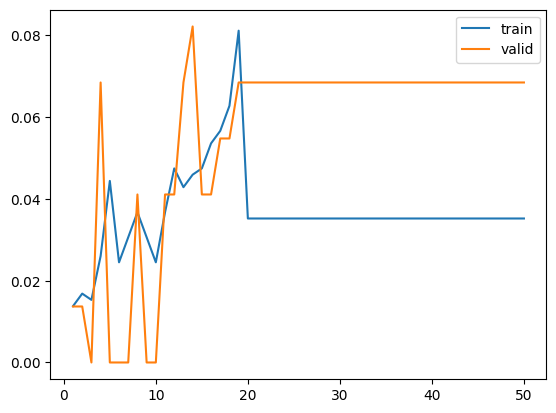

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [53]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [54]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-54-8850fd72ce56>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 1s/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [55]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [57]:
input_text='Te apuesto un'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 65ms/step


'Te apuesto un  '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting, a pesar de que se intentó mejorar múltiples componentes del modelo
